# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

The device used is cpu
X shape is: torch.Size([1000]) and e.shape is equal to: torch.Size([1000])


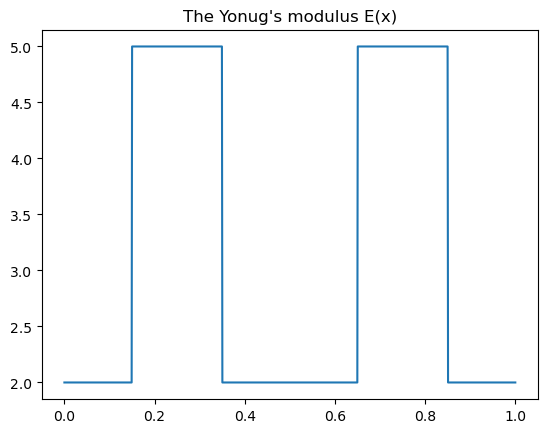

In [13]:
import numpy as np
import matplotlib.pyplot as  plt
import torch 
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device used is", device)

def E_torch(x, phase1=2.0, phase2=5.0):
    return torch.where(
        torch.abs(x-0.5)<0.35, # if abs(x-0.5) is between 0.15 and 0.35 - phase 2, else phase 1
        torch.where(torch.abs(x-0.5)>0.15, torch.tensor(phase2, device=x.device), torch.tensor(phase1, device=x.device)),
        torch.tensor(phase1, device=x.device)
    )

#
x = torch.linspace(0, 1, 1000, dtype=torch.float32).to(device)
e = E_torch(x)
print("X shape is:",x.shape,"and e.shape is equal to:", e.shape)
#
plt.figure()
plt.plot(x,e)
plt.title("The Yonug's modulus E(x)")
plt.show()

## Defining displacement Boundary conditions

In [14]:
### Define the PDEs and BCs
x_bd = torch.tensor([[0.], [1.]], dtype=torch.float32).to(device)  # Dirichlet BCs
print("size of x_bd is:", x_bd.shape)
#
u_bd = torch.tensor([[0.], [0.]], dtype=torch.float32).to(device)  # Dirichlet BCs
print("size of u_bd is:", u_bd.shape)

size of x_bd is: torch.Size([2, 1])
size of u_bd is: torch.Size([2, 1])


## MLP model implementation

In [16]:
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)
    
    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x

    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return x

model_u = MLP([1, 100, 100, 100, 100, 1], dtype=torch.float32).to(device)
from torchsummary import summary
summary(model_u, input_size=(1,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             200
            Linear-2                  [-1, 100]          10,100
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                    [-1, 1]             101
Total params: 30,601
Trainable params: 30,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


## Importing data from the dataset

In [17]:
import h5py
dtype = torch.float32
with h5py.File('1st_task/LinearElasticity1d.h5', 'r') as data:
    print(data.keys())
    x_test = torch.tensor(np.array(data["x_test"]), dtype=dtype).to(device)

    u_test = torch.tensor(np.array(data["u_test"]), dtype=dtype).to(device)
    
print('The shape of x_test:', x_test.shape)
print('The shape of u_test:', u_test.shape)

x = x.unsqueeze(-1).to(device)
e = e.unsqueeze(-1).to(device)
u_test = u_test.unsqueeze(-1)

print("---------------------------")
print('The shape of x:', x.shape)
print('The shape of e:', e.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of x_test:', x_test.shape)

<KeysViewHDF5 ['u_test', 'x_test']>
The shape of x_test: torch.Size([1001, 1])
The shape of u_test: torch.Size([1001])
---------------------------
The shape of x: torch.Size([1000, 1])
The shape of e: torch.Size([1000, 1])
The shape of u_test: torch.Size([1001, 1])
The shape of x_test: torch.Size([1001, 1])


## Creating loss function Mollifier and doing the training process

In [ ]:
from torch.autograd import Variable, grad

class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
        return u * (1 - x) * x

class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
        self.getLoss = torch.nn.MSELoss()
        self.molifier = Mollifier(dim=1)  # 1D problem
        
    def loss_pde(self, x_in, weights):
        # Loss for Deep Ritz Method
        ################# The PDE loss
        x = x_in * 0.5 + 0.5
        x = Variable(x, requires_grad=True).to(self.device)
        x = x.reshape(-1, 1)  # Ensure x is a column vector
        w = weights.to(self.device)
        #
        u = self.u_model(x)
        u = self.molifier.apply(u, x)
        du_dx = grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        fx = 9.81
        # The energy
        energy = torch.sum( (0.5 * E_torch(x) * du_dx**2 - fx*u ) * w * 0.5)
        
        return energy
        
    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.molifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

############ Training setups
from tqdm import trange
#
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
#
lossClass = LossClass(model_u)
## Weights for the PDE loss
n_int = len(x)
x, weights = np.polynomial.legendre.leggauss(n_int)
x = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1,1)
weights = torch.tensor(weights, dtype=torch.float32, device=device).reshape(-1,1)

# Compute L2 relative error
#######################################
def L2_error(u_true, u_pred):
    return torch.norm(u_true - u_pred) / (torch.norm(u_true) + 1e-8)

error_list = []
l2_error_list = []
for epoch in trange(epochs):
    x_interior = torch.linspace(0., 1., 100).unsqueeze(-1).to(device)

    loss_train = lossClass.loss_pde(x, weights)
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    #
    scheduler.step()  # Adjust learning rate

    with torch.no_grad():
        error = lossClass.get_error(x_test, u_test)
        error_list.append(error.item())

        u_pred = model_u(x_test.to(device))
        u_pred = lossClass.molifier.apply(u_pred, x_test.to(device))
        l2_test_error = L2_error(u_test.to(device), u_pred)
        l2_error_list.append(l2_test_error.item())
    
    #
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())


  2%|▏         | 30/2000 [00:00<00:41, 47.82it/s]

Epoch:24, The loss is:-1.5756146907806396, lr: 0.001
0.014293668791651726


  3%|▎         | 57/2000 [00:01<00:33, 58.63it/s]

Epoch:49, The loss is:-1.5870411396026611, lr: 0.001
0.026290547102689743


  4%|▍         | 83/2000 [00:01<00:35, 53.86it/s]

Epoch:74, The loss is:-1.5917760133743286, lr: 0.001
0.02488289214670658


  6%|▌         | 110/2000 [00:02<00:32, 58.88it/s]

Epoch:99, The loss is:-1.5976184606552124, lr: 0.001
0.021348778158426285


  7%|▋         | 137/2000 [00:02<00:30, 60.27it/s]

Epoch:124, The loss is:-1.6049838066101074, lr: 0.001
0.015358018688857555


  8%|▊         | 155/2000 [00:03<00:43, 42.79it/s]

Epoch:149, The loss is:-1.6076111793518066, lr: 0.001
0.012739676982164383


  9%|▉         | 181/2000 [00:03<00:35, 51.04it/s]

Epoch:174, The loss is:-1.60850989818573, lr: 0.001
0.010753247886896133


 10%|█         | 206/2000 [00:03<00:31, 56.98it/s]

Epoch:199, The loss is:-1.6095188856124878, lr: 0.001
0.011523805558681488


 12%|█▏        | 236/2000 [00:04<00:26, 66.12it/s]

Epoch:224, The loss is:-1.610294222831726, lr: 0.001
0.015094388276338577


 13%|█▎        | 258/2000 [00:04<00:26, 66.58it/s]

Epoch:249, The loss is:-1.6115392446517944, lr: 0.001
0.00978652760386467


 14%|█▍        | 281/2000 [00:05<00:25, 66.45it/s]

Epoch:274, The loss is:-1.6119073629379272, lr: 0.001
0.010591262020170689


 16%|█▌        | 311/2000 [00:05<00:24, 69.78it/s]

Epoch:299, The loss is:-1.612581491470337, lr: 0.001
0.010071818716824055


 17%|█▋        | 340/2000 [00:05<00:24, 68.36it/s]

Epoch:324, The loss is:-1.6141364574432373, lr: 0.001
0.008897506631910801


 18%|█▊        | 361/2000 [00:06<00:23, 68.42it/s]

Epoch:349, The loss is:-1.6144517660140991, lr: 0.001
0.013514562509953976


 20%|█▉        | 390/2000 [00:06<00:23, 69.30it/s]

Epoch:374, The loss is:-1.6157320737838745, lr: 0.001
0.006866226904094219


 21%|██        | 411/2000 [00:07<00:23, 67.78it/s]

Epoch:399, The loss is:-1.6160244941711426, lr: 0.001
0.0061984858475625515


 22%|██▏       | 432/2000 [00:07<00:24, 64.32it/s]

Epoch:424, The loss is:-1.6154621839523315, lr: 0.001
0.004212024621665478


 23%|██▎       | 460/2000 [00:07<00:24, 62.90it/s]

Epoch:449, The loss is:-1.6155481338500977, lr: 0.001
0.0058652195148169994


 24%|██▍       | 481/2000 [00:08<00:26, 57.03it/s]

Epoch:474, The loss is:-1.6090896129608154, lr: 0.001
0.009198957122862339


 25%|██▌       | 506/2000 [00:08<00:30, 48.49it/s]

Epoch:499, The loss is:-1.6166375875473022, lr: 0.0005
0.010270742699503899


 27%|██▋       | 532/2000 [00:09<00:27, 53.56it/s]

Epoch:524, The loss is:-1.6174101829528809, lr: 0.0005
0.0055023180320858955


 28%|██▊       | 559/2000 [00:09<00:23, 61.74it/s]

Epoch:549, The loss is:-1.6176539659500122, lr: 0.0005
0.005601660348474979


 29%|██▉       | 587/2000 [00:10<00:22, 63.98it/s]

Epoch:574, The loss is:-1.6178076267242432, lr: 0.0005
0.005517585203051567


 30%|███       | 607/2000 [00:10<00:25, 53.73it/s]

Epoch:599, The loss is:-1.61794114112854, lr: 0.0005
0.0054219565354287624


 32%|███▏      | 637/2000 [00:11<00:27, 50.40it/s]

Epoch:624, The loss is:-1.6180654764175415, lr: 0.0005
0.005335815716534853


 33%|███▎      | 658/2000 [00:11<00:32, 41.73it/s]

Epoch:649, The loss is:-1.6181838512420654, lr: 0.0005
0.005235317628830671


 34%|███▍      | 684/2000 [00:12<00:25, 51.43it/s]

Epoch:674, The loss is:-1.6182994842529297, lr: 0.0005
0.005142221227288246


 35%|███▌      | 708/2000 [00:12<00:26, 48.19it/s]

Epoch:699, The loss is:-1.6184152364730835, lr: 0.0005
0.005053102970123291


 37%|███▋      | 731/2000 [00:13<00:28, 45.21it/s]

Epoch:724, The loss is:-1.6185320615768433, lr: 0.0005
0.0049645546823740005


 38%|███▊      | 756/2000 [00:13<00:27, 44.44it/s]

Epoch:749, The loss is:-1.61865234375, lr: 0.0005
0.0048753004521131516


 39%|███▉      | 783/2000 [00:14<00:21, 55.88it/s]

Epoch:774, The loss is:-1.6187759637832642, lr: 0.0005
0.004783459473401308


 40%|████      | 806/2000 [00:14<00:25, 46.56it/s]

Epoch:799, The loss is:-1.6189035177230835, lr: 0.0005
0.004687280859798193


 42%|████▏     | 832/2000 [00:15<00:20, 57.34it/s]

Epoch:824, The loss is:-1.619033694267273, lr: 0.0005
0.004586260300129652


 43%|████▎     | 859/2000 [00:15<00:19, 59.72it/s]

Epoch:849, The loss is:-1.6191656589508057, lr: 0.0005
0.004480266943573952


 44%|████▍     | 880/2000 [00:16<00:18, 61.23it/s]

Epoch:874, The loss is:-1.6192967891693115, lr: 0.0005
0.004371036775410175


 45%|████▌     | 909/2000 [00:16<00:23, 45.72it/s]

Epoch:899, The loss is:-1.6194243431091309, lr: 0.0005
0.004260242450982332


 46%|████▋     | 927/2000 [00:17<00:45, 23.64it/s]

Epoch:924, The loss is:-1.6195441484451294, lr: 0.0005
0.0041518076322972775


 48%|████▊     | 956/2000 [00:19<00:36, 28.32it/s]

Epoch:949, The loss is:-1.619653582572937, lr: 0.0005
0.004062946420162916


 49%|████▉     | 979/2000 [00:19<00:22, 44.43it/s]

Epoch:974, The loss is:-1.6189582347869873, lr: 0.0005
0.003957045264542103


 50%|█████     | 1010/2000 [00:20<00:21, 46.02it/s]

Epoch:999, The loss is:-1.619720458984375, lr: 0.00025
0.0032997336238622665


 52%|█████▏    | 1031/2000 [00:20<00:26, 36.75it/s]

Epoch:1024, The loss is:-1.619841456413269, lr: 0.00025
0.0037453535478562117


 53%|█████▎    | 1055/2000 [00:21<00:27, 33.90it/s]

Epoch:1049, The loss is:-1.6198899745941162, lr: 0.00025
0.0038185801822692156


 54%|█████▍    | 1080/2000 [00:22<00:20, 45.27it/s]

Epoch:1074, The loss is:-1.6199296712875366, lr: 0.00025
0.0037993777077645063


 55%|█████▌    | 1106/2000 [00:23<00:31, 28.33it/s]

Epoch:1099, The loss is:-1.6199672222137451, lr: 0.00025
0.003758094273507595


 57%|█████▋    | 1132/2000 [00:24<00:24, 35.98it/s]

Epoch:1124, The loss is:-1.6200037002563477, lr: 0.00025
0.0037258919328451157


 58%|█████▊    | 1152/2000 [00:24<00:25, 32.70it/s]

Epoch:1149, The loss is:-1.6200392246246338, lr: 0.00025
0.003693363396450877


 59%|█████▉    | 1184/2000 [00:25<00:20, 39.19it/s]

Epoch:1174, The loss is:-1.6200737953186035, lr: 0.00025
0.0036636360455304384


 60%|██████    | 1205/2000 [00:26<00:18, 43.33it/s]

Epoch:1199, The loss is:-1.6201080083847046, lr: 0.00025
0.0036346125416457653


 61%|██████    | 1224/2000 [00:26<00:14, 53.14it/s]

Epoch:1224, The loss is:-1.6201415061950684, lr: 0.00025
0.0036066335160285234


 63%|██████▎   | 1251/2000 [00:27<00:18, 39.76it/s]

Epoch:1249, The loss is:-1.620174765586853, lr: 0.00025
0.0035795075818896294


 64%|██████▍   | 1287/2000 [00:28<00:17, 41.03it/s]

Epoch:1274, The loss is:-1.6202077865600586, lr: 0.00025
0.0035529083106666803


 65%|██████▌   | 1308/2000 [00:28<00:12, 53.77it/s]

Epoch:1299, The loss is:-1.6202406883239746, lr: 0.00025
0.00352674163877964


 67%|██████▋   | 1332/2000 [00:29<00:13, 48.72it/s]

Epoch:1324, The loss is:-1.6202737092971802, lr: 0.00025
0.0035010469146072865


 68%|██████▊   | 1357/2000 [00:29<00:13, 49.44it/s]

Epoch:1349, The loss is:-1.6203067302703857, lr: 0.00025
0.003475360805168748


 69%|██████▉   | 1379/2000 [00:30<00:13, 47.69it/s]

Epoch:1374, The loss is:-1.62034010887146, lr: 0.00025
0.0034499098546802998


 70%|███████   | 1405/2000 [00:30<00:12, 47.03it/s]

Epoch:1399, The loss is:-1.6203737258911133, lr: 0.00025
0.0034242181573063135


 72%|███████▏  | 1433/2000 [00:31<00:11, 47.99it/s]

Epoch:1424, The loss is:-1.6204075813293457, lr: 0.00025
0.0033987341448664665


 73%|███████▎  | 1460/2000 [00:31<00:10, 51.85it/s]

Epoch:1449, The loss is:-1.6204416751861572, lr: 0.00025
0.003373212181031704


 74%|███████▍  | 1478/2000 [00:32<00:10, 52.19it/s]

Epoch:1474, The loss is:-1.6204766035079956, lr: 0.00025
0.003347173100337386


 75%|███████▌  | 1504/2000 [00:32<00:12, 38.49it/s]

Epoch:1499, The loss is:-1.620511770248413, lr: 0.000125
0.0033211212139576674


 77%|███████▋  | 1532/2000 [00:33<00:09, 48.09it/s]

Epoch:1524, The loss is:-1.620530605316162, lr: 0.000125
0.0033078878186643124


 78%|███████▊  | 1551/2000 [00:33<00:08, 52.41it/s]

Epoch:1549, The loss is:-1.6205487251281738, lr: 0.000125
0.0032944621052592993


 79%|███████▉  | 1583/2000 [00:34<00:09, 42.90it/s]

Epoch:1574, The loss is:-1.6205670833587646, lr: 0.000125
0.0032808140385895967


 80%|████████  | 1606/2000 [00:35<00:11, 33.27it/s]

Epoch:1599, The loss is:-1.6205857992172241, lr: 0.000125
0.0032669170759618282


 82%|████████▏ | 1630/2000 [00:36<00:12, 28.48it/s]

Epoch:1624, The loss is:-1.6206047534942627, lr: 0.000125
0.003252904862165451


 83%|████████▎ | 1657/2000 [00:37<00:12, 28.35it/s]

Epoch:1649, The loss is:-1.620624303817749, lr: 0.000125
0.0032389096450060606


 84%|████████▍ | 1682/2000 [00:38<00:09, 34.13it/s]

Epoch:1674, The loss is:-1.6206438541412354, lr: 0.000125
0.0032244583126157522


 85%|████████▌ | 1704/2000 [00:38<00:07, 38.36it/s]

Epoch:1699, The loss is:-1.6206635236740112, lr: 0.000125
0.0032098412048071623


 87%|████████▋ | 1731/2000 [00:39<00:06, 40.22it/s]

Epoch:1724, The loss is:-1.620684027671814, lr: 0.000125
0.003195040160790086


 88%|████████▊ | 1753/2000 [00:40<00:07, 31.91it/s]

Epoch:1749, The loss is:-1.6207045316696167, lr: 0.000125
0.003179897554218769


 89%|████████▉ | 1780/2000 [00:40<00:05, 38.11it/s]

Epoch:1774, The loss is:-1.6207250356674194, lr: 0.000125
0.0031647286377847195


 90%|█████████ | 1808/2000 [00:41<00:03, 49.35it/s]

Epoch:1799, The loss is:-1.6207464933395386, lr: 0.000125
0.0031492183916270733


 91%|█████████▏| 1828/2000 [00:41<00:02, 57.98it/s]

Epoch:1824, The loss is:-1.6207679510116577, lr: 0.000125
0.003133573569357395


 93%|█████████▎| 1853/2000 [00:42<00:04, 34.36it/s]

Epoch:1849, The loss is:-1.6207892894744873, lr: 0.000125
0.0031175913754850626


 94%|█████████▍| 1879/2000 [00:43<00:03, 33.46it/s]

Epoch:1874, The loss is:-1.6208109855651855, lr: 0.000125
0.003101355629041791


 95%|█████████▌| 1906/2000 [00:44<00:02, 33.30it/s]

Epoch:1899, The loss is:-1.6208330392837524, lr: 0.000125
0.0030847189482301474


 97%|█████████▋| 1932/2000 [00:45<00:01, 36.43it/s]

Epoch:1924, The loss is:-1.620855450630188, lr: 0.000125
0.003068027086555958


 98%|█████████▊| 1957/2000 [00:45<00:01, 40.19it/s]

Epoch:1949, The loss is:-1.620877742767334, lr: 0.000125
0.003051219042390585


 99%|█████████▉| 1982/2000 [00:46<00:00, 42.80it/s]

Epoch:1974, The loss is:-1.620900273323059, lr: 0.000125
0.003033948363736272


100%|██████████| 2000/2000 [00:46<00:00, 42.93it/s]

Epoch:1999, The loss is:-1.6209228038787842, lr: 6.25e-05
0.0030163947958499193


## Plots generating - Task 1

L2 relative error: 3.0164e-03


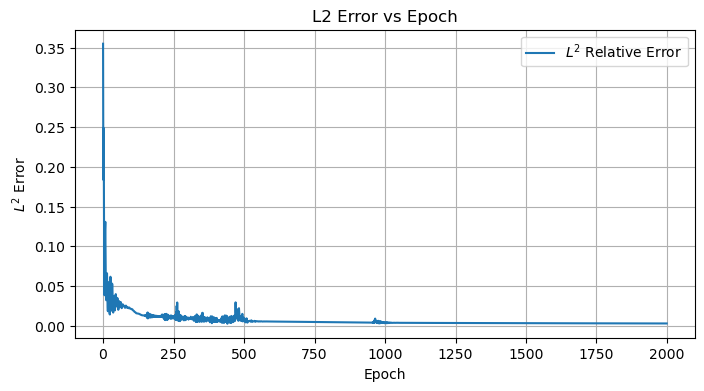

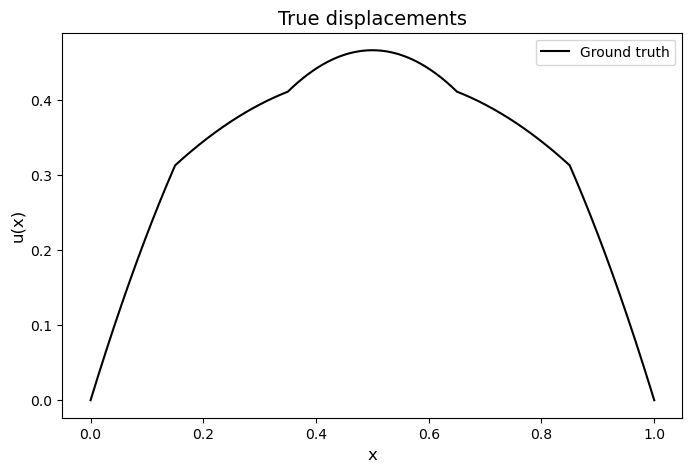

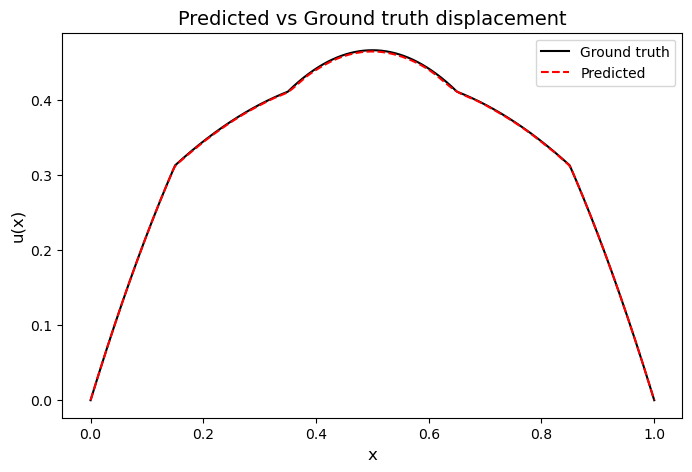

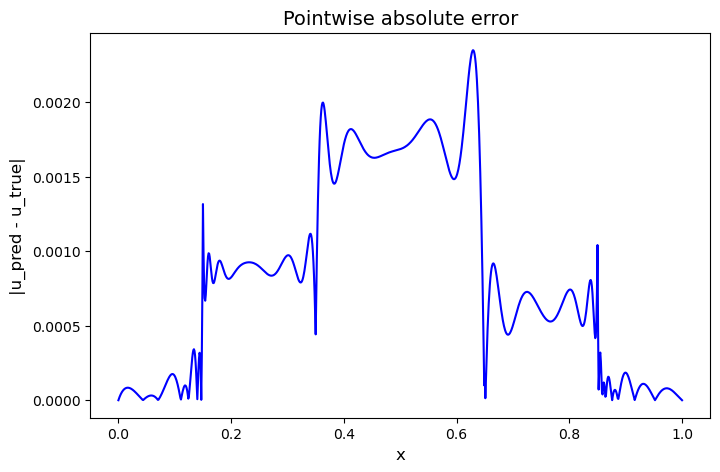

In [19]:
l2_err = L2_error(u_test.cpu(), u_pred)
print(f'L2 relative error: {l2_err.item():.4e}')

#######################################
# Plot results
#######################################

## Plotting the L2 vs epoch error
plt.figure(figsize=(8, 4))
plt.plot(l2_error_list, label='$L^2$ Relative Error')
plt.xlabel('Epoch')
plt.ylabel('$L^2$ Error')
plt.title('L2 Error vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Results
plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), 'k-', label='Ground truth')
plt.legend()
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.title('True displacements', fontsize=14)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), 'k-', label='Ground truth')
plt.plot(x_test.cpu().numpy(), u_pred.cpu().numpy(), 'r--', label='Predicted')
plt.legend()
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.title('Predicted vs Ground truth displacement', fontsize=14)
plt.show()

#######################################
# Plot pointwise absolute error
#######################################
plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), torch.abs(u_pred - u_test).cpu().numpy(), 'b')
plt.xlabel('x', fontsize=12)
plt.ylabel('|u_pred - u_true|', fontsize=12)
plt.title('Pointwise absolute error', fontsize=14)
plt.show()

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>
The shape of x_obs: (250, 1)
The shape of u_obs: (250, 1)
The shape of x_test: (1001, 1)
The shape of u_test: (1001, 1)
The shape of e_test: (1001, 1)
The shape of x_obs: torch.Size([250, 1])
The shape of u_obs: torch.Size([250, 1])
The shape of x_test: torch.Size([1001, 1])
The shape of u_test: torch.Size([1001, 1])
The shape of e_test: torch.Size([1001, 1])


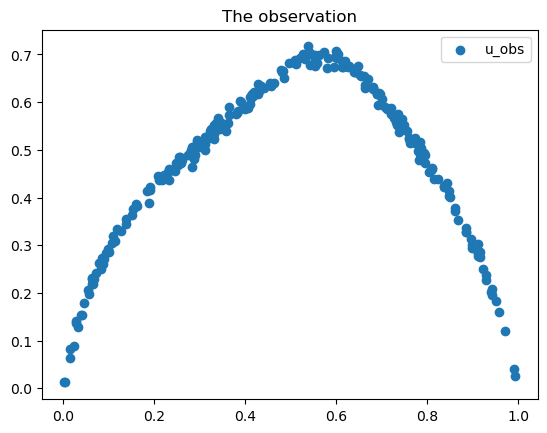

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
#
with h5py.File('1st_task/LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs = np.array(file['x_obs']).reshape(-1,1)
    u_obs = np.array(file['u_obs']).reshape(-1,1)

    x_test = np.array(file['x_test']).reshape(-1,1)
    u_test = np.array(file['u_test']).reshape(-1,1)
    e_test = np.array(file['e_test']).reshape(-1,1)

print('The shape of x_obs:', x_obs.shape)
print('The shape of u_obs:', u_obs.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of e_test:', e_test.shape)


### Using torch tensors in the future ###
## Converting into torch tensors
x_obs = torch.tensor(x_obs, dtype=torch.float32).to(device)
u_obs = torch.tensor(u_obs, dtype=torch.float32).to(device) 
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test, dtype=torch.float32).to(device)
e_test = torch.tensor(e_test, dtype=torch.float32).to(device)
#######################################

print('The shape of x_obs:', x_obs.shape)
print('The shape of u_obs:', u_obs.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of e_test:', e_test.shape)
#
plt.figure()
plt.scatter(x_obs, u_obs, label='u_obs')
plt.title('The observation')
plt.legend()
plt.show()

## Creating Loss function for task 2 - using inverse PINN

In [ ]:
from torch.autograd import Variable, grad

class LossClass(object):

    def __init__(self, u_model, E_model):
        self.device = device
        self.u_model = u_model 
        self.E_model = E_model  # Young's modulus model
        self.getLoss = torch.nn.MSELoss()
        
    def loss_pde(self, x_in, weights):
        # For PIINs 
        x = x_in * 0.5 + 0.5
        x = Variable(x, requires_grad=True).to(self.device)
        x = x.reshape(-1, 1)
        weights = weights.to(self.device)
        E = self.E_model(x).to(self.device)
        ####
        u = self.u_model(x)

        du_dx = grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        ## stress in the material
        stress = E * du_dx

        grad_stress = grad(inputs=x, outputs=stress, grad_outputs=torch.ones_like(stress), create_graph=True)[0]
        
        fx = 9.81

        residuals = ( -grad_stress - fx ) * weights * 0.5

        return self.getLoss(residuals, torch.zeros_like(residuals))

    def loss_data(self, x_obs, u_obs):
        '''Data loss term'''
        x_obs = x_obs.to(self.device)
        u_obs = u_obs.to(self.device)
        u_pred = self.u_model(x_obs)

        return self.getLoss(u_pred, u_obs)
    
    def loss_bd(self, x_bd, u_bd):
        # Boundary condition for displacements
        x_bd = x_bd.to(self.device)
        u = self.u_model(x_bd)
     
        return self.getLoss(u, u_bd)
    
    def E_bc(self, x_bc):
        # Boundary condition for Young's modulus
        x_bc = x_bc.to(self.device)
        E = self.E_model(x_bc)

        return self.getLoss(E, torch.ones_like(E))
    
    def get_error_u(self, x_test, u_test):
        # Error for displacements
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)

        u = u.view(-1)
        u_test = u_test.view(-1)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
    
    def get_error_E(self, x_test, E_test):
        # Error for Young's modulus
        x_test = x_test.to(self.device)
        E_test = E_test.to(self.device)

        E = self.E_model(x_test)
        
        E = E.view(-1)
        E_test = E_test.view(-1)

        return torch.sqrt(torch.sum((E-E_test)**2)/torch.sum(E_test**2))

## Running training with 2 MLP models

In [29]:
from tqdm import trange
#
# Compute L2 relative error
#######################################
def L2_error(u_true, u_pred):
    return torch.norm(u_true - u_pred) / (torch.norm(u_true) + 1e-8)
############ Training setups
epochs = 5000
lr = 1e-3
#defining models
model_u = MLP([1, 200, 200, 200, 200, 1], dtype=torch.float32).to(device)
model_E = MLP([1, 200, 200, 200, 200, 1], dtype=torch.float32).to(device)  # Young's modulus model
#
optimizer = torch.optim.Adam(params= list(model_u.parameters()) + list(model_E.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.2)

lossClass = LossClass(model_u, model_E)
## Weights for the PDE loss
n_int = len(x_obs)
x, weights = np.polynomial.legendre.leggauss(n_int)
x = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1,1)
weights = torch.tensor(weights, dtype=torch.float32, device=device).reshape(-1,1)

w_pde = 200.
w_data = 50.
w_E = 1.
w_bc = 1.
############ The training process
error_list = []
l2_error_list_u = []
l2_error_list_E = []
for epoch in trange(epochs):
    loss_pde = lossClass.loss_pde(x, weights)
    loss_E = lossClass.E_bc(x_bd)
    loss_u_bc = lossClass.loss_bd(x_bd, u_bd)
    loss_data = lossClass.loss_data(x_obs, u_obs)
    
    loss_train = w_pde * loss_pde + w_data * loss_data + w_E * loss_E + w_bc * loss_u_bc

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    scheduler.step()  # Adjust learning rate

    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_E = lossClass.get_error_E(x_test, e_test)
        error_list.append((error_u.item(), error_E.item()))

        u_pred = model_u(x_test.to(device)).to(device)
        E_pred = model_E(x_test.to(device)).to(device)

        l2_test_error_u = L2_error(u_test.to(device), u_pred)
        l2_error_list_u.append(l2_test_error_u.item())

        l2_test_error_E = L2_error(e_test.to(device), E_pred)
        l2_error_list_E.append(l2_test_error_E.item())
    
    
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_list.pop())

  1%|          | 28/5000 [00:01<03:37, 22.83it/s]

Epoch:24, The loss is:0.4545859694480896, lr: 0.001
(0.1705138236284256, 0.5726302862167358)


  1%|          | 52/5000 [00:02<04:16, 19.29it/s]

Epoch:49, The loss is:0.09555109590291977, lr: 0.001
(0.06436370313167572, 0.4303063154220581)


  2%|▏         | 77/5000 [00:03<04:01, 20.39it/s]

Epoch:74, The loss is:0.05037323758006096, lr: 0.001
(0.029143866151571274, 0.33759546279907227)


  2%|▏         | 102/5000 [00:05<05:00, 16.32it/s]

Epoch:99, The loss is:0.027949810028076172, lr: 0.001
(0.020284447818994522, 0.25073084235191345)


  3%|▎         | 127/5000 [00:06<04:43, 17.20it/s]

Epoch:124, The loss is:0.01768362522125244, lr: 0.001
(0.016701526939868927, 0.18818692862987518)


  3%|▎         | 153/5000 [00:08<05:41, 14.19it/s]

Epoch:149, The loss is:0.012479864992201328, lr: 0.001
(0.01504652388393879, 0.15084196627140045)


  4%|▎         | 177/5000 [00:09<03:36, 22.23it/s]

Epoch:174, The loss is:0.012381792068481445, lr: 0.001
(0.014177114702761173, 0.14594262838363647)


  4%|▍         | 203/5000 [00:10<04:01, 19.84it/s]

Epoch:199, The loss is:0.009026847779750824, lr: 0.001
(0.01353851892054081, 0.12208717316389084)


  5%|▍         | 227/5000 [00:11<03:44, 21.27it/s]

Epoch:224, The loss is:0.00781664066016674, lr: 0.001
(0.01307531539350748, 0.10954919457435608)


  5%|▌         | 251/5000 [00:13<03:50, 20.64it/s]

Epoch:249, The loss is:0.02251855470240116, lr: 0.001
(0.013730009086430073, 0.10146668553352356)


  6%|▌         | 278/5000 [00:14<03:27, 22.77it/s]

Epoch:274, The loss is:0.007103574462234974, lr: 0.001
(0.011963791213929653, 0.09878364950418472)


  6%|▌         | 302/5000 [00:15<03:27, 22.68it/s]

Epoch:299, The loss is:0.006610445212572813, lr: 0.001
(0.011458057910203934, 0.09233307838439941)


  7%|▋         | 327/5000 [00:16<03:47, 20.56it/s]

Epoch:324, The loss is:0.02614828757941723, lr: 0.001
(0.011862759478390217, 0.09244748204946518)


  7%|▋         | 352/5000 [00:18<04:37, 16.75it/s]

Epoch:349, The loss is:0.007393757347017527, lr: 0.001
(0.010937683284282684, 0.08769901096820831)


  8%|▊         | 376/5000 [00:19<06:12, 12.41it/s]

Epoch:374, The loss is:0.0061623090878129005, lr: 0.001
(0.010395709425210953, 0.08402981609106064)


  8%|▊         | 403/5000 [00:21<04:00, 19.10it/s]

Epoch:399, The loss is:0.0060055735521018505, lr: 0.001
(0.009887132793664932, 0.08022165298461914)


  9%|▊         | 427/5000 [00:22<04:00, 19.03it/s]

Epoch:424, The loss is:0.01005480159074068, lr: 0.001
(0.008833732455968857, 0.07580744475126266)


  9%|▉         | 453/5000 [00:24<03:45, 20.18it/s]

Epoch:449, The loss is:0.006125718355178833, lr: 0.001
(0.009776325896382332, 0.07674446702003479)


 10%|▉         | 479/5000 [00:25<03:33, 21.20it/s]

Epoch:474, The loss is:0.005712530575692654, lr: 0.001
(0.009233660064637661, 0.0752018541097641)


 10%|█         | 503/5000 [00:26<03:25, 21.84it/s]

Epoch:499, The loss is:0.005836049094796181, lr: 0.001
(0.009159678593277931, 0.06807781010866165)


 11%|█         | 528/5000 [00:27<03:30, 21.23it/s]

Epoch:524, The loss is:0.005986157804727554, lr: 0.001
(0.008872393518686295, 0.07073678076267242)


 11%|█         | 552/5000 [00:28<03:23, 21.90it/s]

Epoch:549, The loss is:0.006283865310251713, lr: 0.001
(0.008491316810250282, 0.07055644690990448)


 12%|█▏        | 579/5000 [00:30<03:28, 21.16it/s]

Epoch:574, The loss is:0.0072869048453867435, lr: 0.001
(0.008186766877770424, 0.06771813333034515)


 12%|█▏        | 603/5000 [00:31<03:23, 21.65it/s]

Epoch:599, The loss is:0.005745062604546547, lr: 0.001
(0.008267202414572239, 0.06646353006362915)


 13%|█▎        | 627/5000 [00:32<03:25, 21.30it/s]

Epoch:624, The loss is:0.007590175606310368, lr: 0.001
(0.008444005623459816, 0.06932249665260315)


 13%|█▎        | 654/5000 [00:33<03:15, 22.25it/s]

Epoch:649, The loss is:0.0055242860689759254, lr: 0.001
(0.008529351092875004, 0.06418690830469131)


 14%|█▎        | 678/5000 [00:34<03:16, 22.01it/s]

Epoch:674, The loss is:0.005341245327144861, lr: 0.001
(0.008101237937808037, 0.06371340155601501)


 14%|█▍        | 702/5000 [00:35<03:20, 21.45it/s]

Epoch:699, The loss is:0.009603260084986687, lr: 0.001
(0.009518265724182129, 0.0656723603606224)


 15%|█▍        | 729/5000 [00:37<03:28, 20.53it/s]

Epoch:724, The loss is:0.005374392494559288, lr: 0.001
(0.007663060910999775, 0.06189298257231712)


 15%|█▌        | 753/5000 [00:38<03:18, 21.40it/s]

Epoch:749, The loss is:0.005673216190189123, lr: 0.001
(0.00738891214132309, 0.061540864408016205)


 16%|█▌        | 777/5000 [00:39<03:12, 21.90it/s]

Epoch:774, The loss is:0.007742471061646938, lr: 0.001
(0.008943728171288967, 0.060204729437828064)


 16%|█▌        | 804/5000 [00:40<03:19, 21.08it/s]

Epoch:799, The loss is:0.005620261654257774, lr: 0.001
(0.007407436612993479, 0.05895227938890457)


 17%|█▋        | 828/5000 [00:41<03:30, 19.82it/s]

Epoch:824, The loss is:0.008106094785034657, lr: 0.001
(0.008285139687359333, 0.06344111263751984)


 17%|█▋        | 852/5000 [00:42<03:13, 21.42it/s]

Epoch:849, The loss is:0.006715038325637579, lr: 0.001
(0.009816000238060951, 0.0579313188791275)


 18%|█▊        | 876/5000 [00:44<03:10, 21.60it/s]

Epoch:874, The loss is:0.00578527944162488, lr: 0.001
(0.007753544952720404, 0.05862445756793022)


 18%|█▊        | 903/5000 [00:45<03:23, 20.18it/s]

Epoch:899, The loss is:0.008404232561588287, lr: 0.001
(0.013536176644265652, 0.056856557726860046)


 19%|█▊        | 927/5000 [00:46<03:20, 20.28it/s]

Epoch:924, The loss is:0.007446856703609228, lr: 0.001
(0.014470846392214298, 0.05769592896103859)


 19%|█▉        | 954/5000 [00:48<03:12, 20.96it/s]

Epoch:949, The loss is:0.011603453196585178, lr: 0.001
(0.020402153953909874, 0.055949583649635315)


 20%|█▉        | 978/5000 [00:49<03:19, 20.19it/s]

Epoch:974, The loss is:0.005847616121172905, lr: 0.001
(0.006766213104128838, 0.055847130715847015)


 20%|██        | 1002/5000 [00:50<03:39, 18.22it/s]

Epoch:999, The loss is:0.00570720573887229, lr: 0.001
(0.007795937824994326, 0.05601377785205841)


 21%|██        | 1028/5000 [00:52<03:23, 19.56it/s]

Epoch:1024, The loss is:0.006494238972663879, lr: 0.001
(0.008380633778870106, 0.05324523150920868)


 21%|██        | 1053/5000 [00:53<03:29, 18.80it/s]

Epoch:1049, The loss is:0.01265829335898161, lr: 0.001
(0.015848688781261444, 0.05928200110793114)


 22%|██▏       | 1078/5000 [00:55<03:23, 19.24it/s]

Epoch:1074, The loss is:0.022572249174118042, lr: 0.001
(0.025712531059980392, 0.0614311508834362)


 22%|██▏       | 1104/5000 [00:57<03:47, 17.12it/s]

Epoch:1099, The loss is:0.005404945462942123, lr: 0.001
(0.00924635585397482, 0.057226188480854034)


 23%|██▎       | 1128/5000 [00:58<03:04, 21.02it/s]

Epoch:1124, The loss is:0.006072331685572863, lr: 0.001
(0.006490873172879219, 0.052871882915496826)


 23%|██▎       | 1152/5000 [00:59<03:13, 19.85it/s]

Epoch:1149, The loss is:0.007945211604237556, lr: 0.001
(0.007884742692112923, 0.05553194135427475)


 24%|██▎       | 1179/5000 [01:00<02:58, 21.43it/s]

Epoch:1174, The loss is:0.005673440173268318, lr: 0.001
(0.006262108217924833, 0.05145698040723801)


 24%|██▍       | 1203/5000 [01:01<02:57, 21.34it/s]

Epoch:1199, The loss is:0.005996285937726498, lr: 0.001
(0.006966690067201853, 0.05209699645638466)


 25%|██▍       | 1227/5000 [01:02<02:55, 21.45it/s]

Epoch:1224, The loss is:0.00592993525788188, lr: 0.001
(0.006886932998895645, 0.05351485684514046)


 25%|██▌       | 1254/5000 [01:04<02:57, 21.14it/s]

Epoch:1249, The loss is:0.00577540835365653, lr: 0.0002
(0.0061005582101643085, 0.05193265527486801)


 26%|██▌       | 1278/5000 [01:05<02:59, 20.69it/s]

Epoch:1274, The loss is:0.004981037229299545, lr: 0.0002
(0.0062407441437244415, 0.05070898309350014)


 26%|██▌       | 1303/5000 [01:06<04:00, 15.39it/s]

Epoch:1299, The loss is:0.004918436519801617, lr: 0.0002
(0.006248936988413334, 0.05057360604405403)


 27%|██▋       | 1328/5000 [01:07<02:54, 21.07it/s]

Epoch:1324, The loss is:0.004906298592686653, lr: 0.0002
(0.006192371249198914, 0.05035233125090599)


 27%|██▋       | 1352/5000 [01:09<03:14, 18.80it/s]

Epoch:1349, The loss is:0.0049002827145159245, lr: 0.0002
(0.006153861526399851, 0.050147753208875656)


 28%|██▊       | 1379/5000 [01:10<02:57, 20.39it/s]

Epoch:1374, The loss is:0.004894774407148361, lr: 0.0002
(0.006121354177594185, 0.04994954913854599)


 28%|██▊       | 1404/5000 [01:12<03:41, 16.21it/s]

Epoch:1399, The loss is:0.004889664705842733, lr: 0.0002
(0.006090759765356779, 0.04975079372525215)


 29%|██▊       | 1428/5000 [01:13<03:01, 19.73it/s]

Epoch:1424, The loss is:0.004884892143309116, lr: 0.0002
(0.0060618179850280285, 0.04955470189452171)


 29%|██▉       | 1452/5000 [01:15<03:10, 18.63it/s]

Epoch:1449, The loss is:0.004880422726273537, lr: 0.0002
(0.006034323945641518, 0.049362704157829285)


 30%|██▉       | 1478/5000 [01:16<02:46, 21.10it/s]

Epoch:1474, The loss is:0.004876177292317152, lr: 0.0002
(0.00600796053186059, 0.04917505010962486)


 30%|███       | 1504/5000 [01:17<02:51, 20.44it/s]

Epoch:1499, The loss is:0.004872175864875317, lr: 0.0002
(0.005982529371976852, 0.04899094998836517)


 31%|███       | 1528/5000 [01:18<02:43, 21.28it/s]

Epoch:1524, The loss is:0.00486834766343236, lr: 0.0002
(0.005957991350442171, 0.04881029203534126)


 31%|███       | 1553/5000 [01:20<04:33, 12.59it/s]

Epoch:1549, The loss is:0.004864690825343132, lr: 0.0002
(0.005934101063758135, 0.04863257333636284)


 32%|███▏      | 1578/5000 [01:22<02:45, 20.64it/s]

Epoch:1574, The loss is:0.0048611778765916824, lr: 0.0002
(0.00591081939637661, 0.048457708209753036)


 32%|███▏      | 1604/5000 [01:23<02:54, 19.50it/s]

Epoch:1599, The loss is:0.0048578111454844475, lr: 0.0002
(0.005888120736926794, 0.0482855848968029)


 33%|███▎      | 1628/5000 [01:24<02:44, 20.55it/s]

Epoch:1624, The loss is:0.004854538477957249, lr: 0.0002
(0.005865947809070349, 0.0481160432100296)


 33%|███▎      | 1652/5000 [01:25<02:38, 21.13it/s]

Epoch:1649, The loss is:0.004851378966122866, lr: 0.0002
(0.00584409199655056, 0.04794880747795105)


 34%|███▎      | 1679/5000 [01:27<02:37, 21.14it/s]

Epoch:1674, The loss is:0.004848336335271597, lr: 0.0002
(0.005822672974318266, 0.04778430238366127)


 34%|███▍      | 1704/5000 [01:28<02:47, 19.69it/s]

Epoch:1699, The loss is:0.004845346789807081, lr: 0.0002
(0.005801670253276825, 0.04762253165245056)


 35%|███▍      | 1728/5000 [01:29<02:52, 19.02it/s]

Epoch:1724, The loss is:0.004842450842261314, lr: 0.0002
(0.005781044252216816, 0.04746345803141594)


 35%|███▌      | 1750/5000 [01:31<04:13, 12.82it/s]

Epoch:1749, The loss is:0.004839643370360136, lr: 0.0002
(0.005760664585977793, 0.04730689898133278)


 36%|███▌      | 1776/5000 [01:33<05:43,  9.39it/s]

Epoch:1774, The loss is:0.004836894106119871, lr: 0.0002
(0.005740770138800144, 0.04715370014309883)


 36%|███▌      | 1802/5000 [01:35<03:31, 15.13it/s]

Epoch:1799, The loss is:0.004834216553717852, lr: 0.0002
(0.005721057765185833, 0.04700341820716858)


 37%|███▋      | 1828/5000 [01:38<03:52, 13.63it/s]

Epoch:1824, The loss is:0.0048315986059606075, lr: 0.0002
(0.005701790563762188, 0.04685613885521889)


 37%|███▋      | 1851/5000 [01:40<04:15, 12.34it/s]

Epoch:1849, The loss is:0.0048290640115737915, lr: 0.0002
(0.005682787392288446, 0.04671217501163483)


 38%|███▊      | 1877/5000 [01:42<04:48, 10.83it/s]

Epoch:1874, The loss is:0.004826560150831938, lr: 0.0002
(0.005664087366312742, 0.04657142236828804)


 38%|███▊      | 1903/5000 [01:44<02:46, 18.65it/s]

Epoch:1899, The loss is:0.004824125207960606, lr: 0.0002
(0.005645666737109423, 0.04643367603421211)


 39%|███▊      | 1927/5000 [01:46<04:27, 11.50it/s]

Epoch:1924, The loss is:0.004821752198040485, lr: 0.0002
(0.005627613049000502, 0.04629921168088913)


 39%|███▉      | 1952/5000 [01:48<03:09, 16.12it/s]

Epoch:1949, The loss is:0.0048194159753620625, lr: 0.0002
(0.005609864369034767, 0.04616807773709297)


 40%|███▉      | 1978/5000 [01:49<02:33, 19.69it/s]

Epoch:1974, The loss is:0.004817120265215635, lr: 0.0002
(0.005592412780970335, 0.046040378510951996)


 40%|████      | 2004/5000 [01:50<02:27, 20.29it/s]

Epoch:1999, The loss is:0.004814904183149338, lr: 0.0002
(0.005575293209403753, 0.04591607302427292)


 41%|████      | 2026/5000 [01:51<02:34, 19.31it/s]

Epoch:2024, The loss is:0.004812702536582947, lr: 0.0002
(0.005558381322771311, 0.04579498991370201)


 41%|████      | 2052/5000 [01:53<02:23, 20.60it/s]

Epoch:2049, The loss is:0.00481056421995163, lr: 0.0002
(0.0055418009869754314, 0.04567718133330345)


 42%|████▏     | 2075/5000 [01:54<02:38, 18.48it/s]

Epoch:2074, The loss is:0.004808463621884584, lr: 0.0002
(0.005525507032871246, 0.045562732964754105)


 42%|████▏     | 2103/5000 [01:56<03:29, 13.82it/s]

Epoch:2099, The loss is:0.004806397948414087, lr: 0.0002
(0.005509607028216124, 0.04545149207115173)


 43%|████▎     | 2128/5000 [01:58<02:29, 19.15it/s]

Epoch:2124, The loss is:0.004804390482604504, lr: 0.0002
(0.005493892822414637, 0.04534328356385231)


 43%|████▎     | 2152/5000 [01:59<02:58, 15.98it/s]

Epoch:2149, The loss is:0.004802410025149584, lr: 0.0002
(0.005478504579514265, 0.04523831605911255)


 44%|████▎     | 2177/5000 [02:01<02:26, 19.29it/s]

Epoch:2174, The loss is:0.004800456576049328, lr: 0.0002
(0.005463351495563984, 0.04513629525899887)


 44%|████▍     | 2204/5000 [02:02<02:52, 16.20it/s]

Epoch:2199, The loss is:0.004798554815351963, lr: 0.0002
(0.005448587704449892, 0.04503718391060829)


 45%|████▍     | 2227/5000 [02:04<03:31, 13.10it/s]

Epoch:2224, The loss is:0.004796680994331837, lr: 0.0002
(0.005433998536318541, 0.04494071006774902)


 45%|████▌     | 2252/5000 [02:06<03:08, 14.59it/s]

Epoch:2249, The loss is:0.004794851411134005, lr: 0.0002
(0.005419739987701178, 0.04484708607196808)


 46%|████▌     | 2279/5000 [02:08<02:25, 18.64it/s]

Epoch:2274, The loss is:0.0047930325381457806, lr: 0.0002
(0.005405732896178961, 0.044755786657333374)


 46%|████▌     | 2301/5000 [02:09<02:12, 20.34it/s]

Epoch:2299, The loss is:0.004791252315044403, lr: 0.0002
(0.005392006132751703, 0.04466722160577774)


 47%|████▋     | 2327/5000 [02:11<02:58, 15.00it/s]

Epoch:2324, The loss is:0.0047895172610878944, lr: 0.0002
(0.005378486588597298, 0.044581130146980286)


 47%|████▋     | 2353/5000 [02:12<02:40, 16.46it/s]

Epoch:2349, The loss is:0.0047878073528409, lr: 0.0002
(0.005365193821489811, 0.04449736699461937)


 48%|████▊     | 2376/5000 [02:13<02:09, 20.20it/s]

Epoch:2374, The loss is:0.004786109086126089, lr: 0.0002
(0.005352281965315342, 0.044415950775146484)


 48%|████▊     | 2403/5000 [02:15<02:22, 18.26it/s]

Epoch:2399, The loss is:0.00478445366024971, lr: 0.0002
(0.005339531227946281, 0.044336508959531784)


 49%|████▊     | 2428/5000 [02:17<02:40, 16.05it/s]

Epoch:2424, The loss is:0.004782822914421558, lr: 0.0002
(0.005326995626091957, 0.04425903409719467)


 49%|████▉     | 2453/5000 [02:18<02:17, 18.46it/s]

Epoch:2449, The loss is:0.004781223367899656, lr: 0.0002
(0.005314672831445932, 0.04418349638581276)


 50%|████▉     | 2479/5000 [02:20<02:12, 19.02it/s]

Epoch:2474, The loss is:0.0047796363942325115, lr: 0.0002
(0.005302672740072012, 0.044109512120485306)


 50%|█████     | 2502/5000 [02:21<02:24, 17.30it/s]

Epoch:2499, The loss is:0.00477808341383934, lr: 4e-05
(0.005290791392326355, 0.04403737187385559)


 51%|█████     | 2526/5000 [02:23<03:09, 13.05it/s]

Epoch:2524, The loss is:0.004777721595019102, lr: 4e-05
(0.00528844865038991, 0.0440228171646595)


 51%|█████     | 2553/5000 [02:25<02:31, 16.12it/s]

Epoch:2549, The loss is:0.004777403548359871, lr: 4e-05
(0.005286089610308409, 0.04400824010372162)


 52%|█████▏    | 2577/5000 [02:26<04:31,  8.92it/s]

Epoch:2574, The loss is:0.004777091555297375, lr: 4e-05
(0.00528371799737215, 0.04399365559220314)


 52%|█████▏    | 2602/5000 [02:28<02:18, 17.32it/s]

Epoch:2599, The loss is:0.004776772577315569, lr: 4e-05
(0.005281361751258373, 0.04397928714752197)


 53%|█████▎    | 2629/5000 [02:30<01:56, 20.30it/s]

Epoch:2624, The loss is:0.004776453133672476, lr: 4e-05
(0.005278939846903086, 0.043964777141809464)


 53%|█████▎    | 2653/5000 [02:31<02:12, 17.68it/s]

Epoch:2649, The loss is:0.004776132293045521, lr: 4e-05
(0.005276528187096119, 0.04395006224513054)


 54%|█████▎    | 2677/5000 [02:33<02:41, 14.40it/s]

Epoch:2674, The loss is:0.0047758049331605434, lr: 4e-05
(0.005274140276014805, 0.04393522068858147)


 54%|█████▍    | 2702/5000 [02:34<02:32, 15.11it/s]

Epoch:2699, The loss is:0.004775493871420622, lr: 4e-05
(0.005271632689982653, 0.04392029345035553)


 55%|█████▍    | 2727/5000 [02:36<02:02, 18.59it/s]

Epoch:2724, The loss is:0.004775159060955048, lr: 4e-05
(0.005269194487482309, 0.04390528425574303)


 55%|█████▌    | 2751/5000 [02:37<02:33, 14.68it/s]

Epoch:2749, The loss is:0.004774821922183037, lr: 4e-05
(0.005266688298434019, 0.04389004036784172)


 56%|█████▌    | 2778/5000 [02:39<02:34, 14.41it/s]

Epoch:2774, The loss is:0.004774497356265783, lr: 4e-05
(0.00526414392516017, 0.04387488216161728)


 56%|█████▌    | 2802/5000 [02:41<02:33, 14.28it/s]

Epoch:2799, The loss is:0.004774156492203474, lr: 4e-05
(0.005261648911982775, 0.04385954141616821)


 57%|█████▋    | 2826/5000 [02:43<02:11, 16.58it/s]

Epoch:2824, The loss is:0.004773814231157303, lr: 4e-05
(0.005259087774902582, 0.04384399205446243)


 57%|█████▋    | 2853/5000 [02:44<02:08, 16.68it/s]

Epoch:2849, The loss is:0.004773473367094994, lr: 4e-05
(0.005256554577499628, 0.043828509747982025)


 58%|█████▊    | 2877/5000 [02:46<01:55, 18.38it/s]

Epoch:2874, The loss is:0.004773136228322983, lr: 4e-05
(0.005253983661532402, 0.043812815099954605)


 58%|█████▊    | 2904/5000 [02:47<01:56, 17.95it/s]

Epoch:2899, The loss is:0.00477278046309948, lr: 4e-05
(0.005251386668533087, 0.04379706829786301)


 59%|█████▊    | 2926/5000 [02:49<02:10, 15.90it/s]

Epoch:2924, The loss is:0.0047724442556500435, lr: 4e-05
(0.0052487668581306934, 0.043781355023384094)


 59%|█████▉    | 2952/5000 [02:51<02:18, 14.84it/s]

Epoch:2949, The loss is:0.004772092215716839, lr: 4e-05
(0.005246143788099289, 0.043765436857938766)


 60%|█████▉    | 2977/5000 [02:52<01:47, 18.84it/s]

Epoch:2974, The loss is:0.004771742038428783, lr: 4e-05
(0.005243506282567978, 0.04374932870268822)


 60%|██████    | 3003/5000 [02:54<01:46, 18.81it/s]

Epoch:2999, The loss is:0.004771384410560131, lr: 4e-05
(0.0052408636547625065, 0.043733153492212296)


 61%|██████    | 3027/5000 [02:55<01:47, 18.27it/s]

Epoch:3024, The loss is:0.004771021194756031, lr: 4e-05
(0.005238187499344349, 0.04371689632534981)


 61%|██████    | 3053/5000 [02:57<01:37, 19.90it/s]

Epoch:3049, The loss is:0.0047706556506454945, lr: 4e-05
(0.005235479678958654, 0.04370053857564926)


 62%|██████▏   | 3077/5000 [02:58<01:33, 20.55it/s]

Epoch:3074, The loss is:0.004770291969180107, lr: 4e-05
(0.0052328091114759445, 0.04368419200181961)


 62%|██████▏   | 3103/5000 [02:59<01:51, 17.00it/s]

Epoch:3099, The loss is:0.004769943654537201, lr: 4e-05
(0.0052300868555903435, 0.043667543679475784)


 63%|██████▎   | 3127/5000 [03:01<01:38, 18.98it/s]

Epoch:3124, The loss is:0.004769575782120228, lr: 4e-05
(0.005227365996688604, 0.04365091770887375)


 63%|██████▎   | 3154/5000 [03:02<01:46, 17.38it/s]

Epoch:3149, The loss is:0.004769195802509785, lr: 4e-05
(0.0052246456034481525, 0.043634187430143356)


 64%|██████▎   | 3179/5000 [03:04<01:35, 19.11it/s]

Epoch:3174, The loss is:0.004768831189721823, lr: 4e-05
(0.005221890285611153, 0.04361742362380028)


 64%|██████▍   | 3203/5000 [03:05<01:29, 19.99it/s]

Epoch:3199, The loss is:0.004768452141433954, lr: 4e-05
(0.005219117738306522, 0.04360044002532959)


 65%|██████▍   | 3227/5000 [03:06<01:25, 20.73it/s]

Epoch:3224, The loss is:0.004768069833517075, lr: 4e-05
(0.005216341000050306, 0.043583329766988754)


 65%|██████▌   | 3253/5000 [03:07<01:35, 18.20it/s]

Epoch:3249, The loss is:0.0047676884569227695, lr: 4e-05
(0.005213541444391012, 0.043566200882196426)


 66%|██████▌   | 3279/5000 [03:09<01:23, 20.58it/s]

Epoch:3274, The loss is:0.004767310805618763, lr: 4e-05
(0.005210689269006252, 0.043548695743083954)


 66%|██████▌   | 3303/5000 [03:10<01:20, 20.99it/s]

Epoch:3299, The loss is:0.004766922909766436, lr: 4e-05
(0.005207866430282593, 0.04353120177984238)


 67%|██████▋   | 3327/5000 [03:11<01:20, 20.69it/s]

Epoch:3324, The loss is:0.004766544327139854, lr: 4e-05
(0.005205024499446154, 0.04351356625556946)


 67%|██████▋   | 3353/5000 [03:12<01:21, 20.29it/s]

Epoch:3349, The loss is:0.00476616807281971, lr: 4e-05
(0.005202176980674267, 0.04349590837955475)


 68%|██████▊   | 3377/5000 [03:14<01:20, 20.23it/s]

Epoch:3374, The loss is:0.004765762947499752, lr: 4e-05
(0.0051993089728057384, 0.043478213250637054)


 68%|██████▊   | 3404/5000 [03:15<01:16, 20.99it/s]

Epoch:3399, The loss is:0.0047653717920184135, lr: 4e-05
(0.0051964460872113705, 0.04346039146184921)


 69%|██████▊   | 3428/5000 [03:16<01:17, 20.24it/s]

Epoch:3424, The loss is:0.004764983430504799, lr: 4e-05
(0.005193532910197973, 0.043442483991384506)


 69%|██████▉   | 3451/5000 [03:17<01:32, 16.79it/s]

Epoch:3449, The loss is:0.0047645652666687965, lr: 4e-05
(0.005190672352910042, 0.043424490839242935)


 70%|██████▉   | 3477/5000 [03:19<01:27, 17.34it/s]

Epoch:3474, The loss is:0.004764164797961712, lr: 4e-05
(0.00518772890791297, 0.0434064045548439)


 70%|███████   | 3503/5000 [03:20<01:35, 15.62it/s]

Epoch:3499, The loss is:0.0047637769021093845, lr: 4e-05
(0.00518479710444808, 0.04338822886347771)


 71%|███████   | 3527/5000 [03:22<01:23, 17.60it/s]

Epoch:3524, The loss is:0.004763379693031311, lr: 4e-05
(0.005181822460144758, 0.043369829654693604)


 71%|███████   | 3554/5000 [03:23<01:15, 19.20it/s]

Epoch:3549, The loss is:0.0047629536129534245, lr: 4e-05
(0.005178894381970167, 0.04335135966539383)


 72%|███████▏  | 3579/5000 [03:25<01:23, 17.12it/s]

Epoch:3574, The loss is:0.004762561991810799, lr: 4e-05
(0.005175958853214979, 0.04333255812525749)


 72%|███████▏  | 3603/5000 [03:26<01:12, 19.18it/s]

Epoch:3599, The loss is:0.00476214149966836, lr: 4e-05
(0.005172949284315109, 0.04331391677260399)


 73%|███████▎  | 3627/5000 [03:27<01:06, 20.58it/s]

Epoch:3624, The loss is:0.004761733114719391, lr: 4e-05
(0.005169979762285948, 0.04329514876008034)


 73%|███████▎  | 3652/5000 [03:29<01:21, 16.63it/s]

Epoch:3649, The loss is:0.004761320073157549, lr: 4e-05
(0.005166987888514996, 0.043276261538267136)


 74%|███████▎  | 3678/5000 [03:30<01:19, 16.53it/s]

Epoch:3674, The loss is:0.00476089445874095, lr: 4e-05
(0.005163959227502346, 0.0432572141289711)


 74%|███████▍  | 3701/5000 [03:32<01:47, 12.11it/s]

Epoch:3699, The loss is:0.004760474897921085, lr: 4e-05
(0.005160881672054529, 0.043237995356321335)


 75%|███████▍  | 3728/5000 [03:33<01:15, 16.92it/s]

Epoch:3724, The loss is:0.004760057665407658, lr: 4e-05
(0.005157864186912775, 0.04321865364909172)


 75%|███████▌  | 3752/5000 [03:35<01:03, 19.61it/s]

Epoch:3749, The loss is:0.004759637173265219, lr: 8.000000000000001e-06
(0.005154784303158522, 0.04319912940263748)


 76%|███████▌  | 3779/5000 [03:36<00:58, 20.89it/s]

Epoch:3774, The loss is:0.004759541247040033, lr: 8.000000000000001e-06
(0.005154269281774759, 0.0431947186589241)


 76%|███████▌  | 3801/5000 [03:37<00:59, 20.14it/s]

Epoch:3799, The loss is:0.004759456031024456, lr: 8.000000000000001e-06
(0.005153648555278778, 0.04319019988179207)


 77%|███████▋  | 3826/5000 [03:39<01:19, 14.80it/s]

Epoch:3824, The loss is:0.004759353585541248, lr: 8.000000000000001e-06
(0.005152995232492685, 0.04318583384156227)


 77%|███████▋  | 3852/5000 [03:41<01:21, 14.03it/s]

Epoch:3849, The loss is:0.004759273026138544, lr: 8.000000000000001e-06
(0.00515237171202898, 0.04318144917488098)


 78%|███████▊  | 3878/5000 [03:42<00:54, 20.75it/s]

Epoch:3874, The loss is:0.0047591812908649445, lr: 8.000000000000001e-06
(0.005151733756065369, 0.04317699745297432)


 78%|███████▊  | 3902/5000 [03:43<00:52, 20.99it/s]

Epoch:3899, The loss is:0.004759102128446102, lr: 8.000000000000001e-06
(0.005151075776666403, 0.04317242279648781)


 79%|███████▊  | 3926/5000 [03:45<00:52, 20.58it/s]

Epoch:3924, The loss is:0.004759018309414387, lr: 8.000000000000001e-06
(0.005150440614670515, 0.04316786304116249)


 79%|███████▉  | 3953/5000 [03:46<00:50, 20.71it/s]

Epoch:3949, The loss is:0.004758915863931179, lr: 8.000000000000001e-06
(0.005149752367287874, 0.04316325858235359)


 80%|███████▉  | 3977/5000 [03:47<00:49, 20.52it/s]

Epoch:3974, The loss is:0.004758826456964016, lr: 8.000000000000001e-06
(0.005149099510163069, 0.04315872862935066)


 80%|████████  | 4002/5000 [03:48<00:52, 18.87it/s]

Epoch:3999, The loss is:0.004758735187351704, lr: 8.000000000000001e-06
(0.005148410797119141, 0.04315415769815445)


 81%|████████  | 4027/5000 [03:50<00:48, 20.27it/s]

Epoch:4024, The loss is:0.004758633207529783, lr: 8.000000000000001e-06
(0.0051477462984621525, 0.04314960539340973)


 81%|████████  | 4053/5000 [03:51<00:53, 17.76it/s]

Epoch:4049, The loss is:0.004758551251143217, lr: 8.000000000000001e-06
(0.005147061310708523, 0.0431450754404068)


 82%|████████▏ | 4077/5000 [03:52<00:46, 19.89it/s]

Epoch:4074, The loss is:0.004758440423756838, lr: 8.000000000000001e-06
(0.0051463753916323185, 0.04314045608043671)


 82%|████████▏ | 4103/5000 [03:54<00:47, 18.90it/s]

Epoch:4099, The loss is:0.004758355673402548, lr: 8.000000000000001e-06
(0.0051456657238304615, 0.04313574358820915)


 83%|████████▎ | 4127/5000 [03:55<00:44, 19.83it/s]

Epoch:4124, The loss is:0.004758249502629042, lr: 8.000000000000001e-06
(0.005144964437931776, 0.043131086975336075)


 83%|████████▎ | 4152/5000 [03:56<00:42, 20.06it/s]

Epoch:4149, The loss is:0.004758154973387718, lr: 8.000000000000001e-06
(0.005144256632775068, 0.043126363307237625)


 84%|████████▎ | 4179/5000 [03:58<00:39, 20.56it/s]

Epoch:4174, The loss is:0.004758043680340052, lr: 8.000000000000001e-06
(0.005143528338521719, 0.0431215837597847)


 84%|████████▍ | 4202/5000 [03:59<00:39, 19.96it/s]

Epoch:4199, The loss is:0.0047579435631632805, lr: 8.000000000000001e-06
(0.0051428270526230335, 0.04311670362949371)


 85%|████████▍ | 4229/5000 [04:00<00:38, 20.17it/s]

Epoch:4224, The loss is:0.00475782947614789, lr: 8.000000000000001e-06
(0.0051420885138213634, 0.04311168193817139)


 85%|████████▌ | 4253/5000 [04:01<00:35, 20.79it/s]

Epoch:4249, The loss is:0.004757731221616268, lr: 8.000000000000001e-06
(0.005141315516084433, 0.04310663416981697)


 86%|████████▌ | 4277/5000 [04:02<00:33, 21.33it/s]

Epoch:4274, The loss is:0.0047576348297297955, lr: 8.000000000000001e-06
(0.00514058256521821, 0.04310160130262375)


 86%|████████▌ | 4303/5000 [04:04<00:38, 18.32it/s]

Epoch:4299, The loss is:0.00475752679631114, lr: 8.000000000000001e-06
(0.005139845423400402, 0.04309646040201187)


 87%|████████▋ | 4329/5000 [04:05<00:36, 18.22it/s]

Epoch:4324, The loss is:0.0047574276104569435, lr: 8.000000000000001e-06
(0.00513900863006711, 0.04309127852320671)


 87%|████████▋ | 4352/5000 [04:06<00:31, 20.58it/s]

Epoch:4349, The loss is:0.004757323767989874, lr: 8.000000000000001e-06
(0.005138236563652754, 0.04308600351214409)


 88%|████████▊ | 4376/5000 [04:08<00:30, 20.26it/s]

Epoch:4374, The loss is:0.004757196642458439, lr: 8.000000000000001e-06
(0.005137436091899872, 0.04308073967695236)


 88%|████████▊ | 4402/5000 [04:09<00:31, 18.72it/s]

Epoch:4399, The loss is:0.0047571007162332535, lr: 8.000000000000001e-06
(0.0051366472616791725, 0.043075524270534515)


 89%|████████▊ | 4427/5000 [04:10<00:33, 17.11it/s]

Epoch:4424, The loss is:0.004756983369588852, lr: 8.000000000000001e-06
(0.005135881714522839, 0.04307017847895622)


 89%|████████▉ | 4453/5000 [04:12<00:32, 16.59it/s]

Epoch:4449, The loss is:0.0047568571753799915, lr: 8.000000000000001e-06
(0.005135027691721916, 0.04306482523679733)


 90%|████████▉ | 4478/5000 [04:13<00:26, 19.91it/s]

Epoch:4474, The loss is:0.004756747744977474, lr: 8.000000000000001e-06
(0.005134217906743288, 0.04305931180715561)


 90%|█████████ | 4501/5000 [04:14<00:27, 18.31it/s]

Epoch:4499, The loss is:0.00475663784891367, lr: 8.000000000000001e-06
(0.005133369471877813, 0.04305382817983627)


 91%|█████████ | 4527/5000 [04:17<00:28, 16.47it/s]

Epoch:4524, The loss is:0.00475652702152729, lr: 8.000000000000001e-06
(0.005132552236318588, 0.04304825887084007)


 91%|█████████ | 4553/5000 [04:18<00:21, 20.34it/s]

Epoch:4549, The loss is:0.004756394773721695, lr: 8.000000000000001e-06
(0.005131691228598356, 0.0430426262319088)


 92%|█████████▏| 4577/5000 [04:19<00:20, 20.54it/s]

Epoch:4574, The loss is:0.004756274167448282, lr: 8.000000000000001e-06
(0.0051308320835232735, 0.043036993592977524)


 92%|█████████▏| 4602/5000 [04:20<00:21, 18.72it/s]

Epoch:4599, The loss is:0.00475615868344903, lr: 8.000000000000001e-06
(0.005129990167915821, 0.04303127899765968)


 93%|█████████▎| 4628/5000 [04:22<00:17, 20.72it/s]

Epoch:4624, The loss is:0.004756030160933733, lr: 8.000000000000001e-06
(0.0051290784031152725, 0.04302551969885826)


 93%|█████████▎| 4653/5000 [04:23<00:18, 19.17it/s]

Epoch:4649, The loss is:0.00475590443238616, lr: 8.000000000000001e-06
(0.005128209944814444, 0.04301965609192848)


 94%|█████████▎| 4677/5000 [04:24<00:15, 20.42it/s]

Epoch:4674, The loss is:0.004755780566483736, lr: 8.000000000000001e-06
(0.005127291660755873, 0.04301366209983826)


 94%|█████████▍| 4701/5000 [04:26<00:22, 13.23it/s]

Epoch:4699, The loss is:0.004755663685500622, lr: 8.000000000000001e-06
(0.005126400385051966, 0.043007828295230865)


 95%|█████████▍| 4727/5000 [04:28<00:20, 13.04it/s]

Epoch:4724, The loss is:0.004755519796162844, lr: 8.000000000000001e-06
(0.005125504918396473, 0.0430019311606884)


 95%|█████████▌| 4753/5000 [04:30<00:15, 16.07it/s]

Epoch:4749, The loss is:0.0047553954645991325, lr: 8.000000000000001e-06
(0.00512460432946682, 0.04299603030085564)


 96%|█████████▌| 4778/5000 [04:32<00:12, 18.07it/s]

Epoch:4774, The loss is:0.00475526787340641, lr: 8.000000000000001e-06
(0.005123681854456663, 0.042990028858184814)


 96%|█████████▌| 4802/5000 [04:33<00:13, 14.74it/s]

Epoch:4799, The loss is:0.0047551351599395275, lr: 8.000000000000001e-06
(0.005122748203575611, 0.042983852326869965)


 97%|█████████▋| 4829/5000 [04:35<00:09, 18.65it/s]

Epoch:4824, The loss is:0.004754994995892048, lr: 8.000000000000001e-06
(0.005121786147356033, 0.0429777093231678)


 97%|█████████▋| 4852/5000 [04:36<00:07, 20.58it/s]

Epoch:4849, The loss is:0.004754857160151005, lr: 8.000000000000001e-06
(0.005120846442878246, 0.04297150671482086)


 98%|█████████▊| 4878/5000 [04:37<00:06, 19.39it/s]

Epoch:4874, The loss is:0.004754724912345409, lr: 8.000000000000001e-06
(0.0051198978908360004, 0.04296528548002243)


 98%|█████████▊| 4903/5000 [04:39<00:04, 20.56it/s]

Epoch:4899, The loss is:0.004754595924168825, lr: 8.000000000000001e-06
(0.005118938162922859, 0.04295896738767624)


 99%|█████████▊| 4927/5000 [04:40<00:03, 18.86it/s]

Epoch:4924, The loss is:0.004754453897476196, lr: 8.000000000000001e-06
(0.0051179626025259495, 0.04295245558023453)


 99%|█████████▉| 4952/5000 [04:41<00:02, 20.27it/s]

Epoch:4949, The loss is:0.004754295572638512, lr: 8.000000000000001e-06
(0.0051169865764677525, 0.042945750057697296)


100%|█████████▉| 4978/5000 [04:43<00:01, 17.35it/s]

Epoch:4974, The loss is:0.004754169378429651, lr: 8.000000000000001e-06
(0.005115970969200134, 0.04293905571103096)


100%|██████████| 5000/5000 [04:44<00:00, 17.58it/s]

Epoch:4999, The loss is:0.004754024092108011, lr: 1.6000000000000004e-06
(0.005114981904625893, 0.04293227195739746)


## Generating plots for task 2

L2 relative error: 5.1150e-03


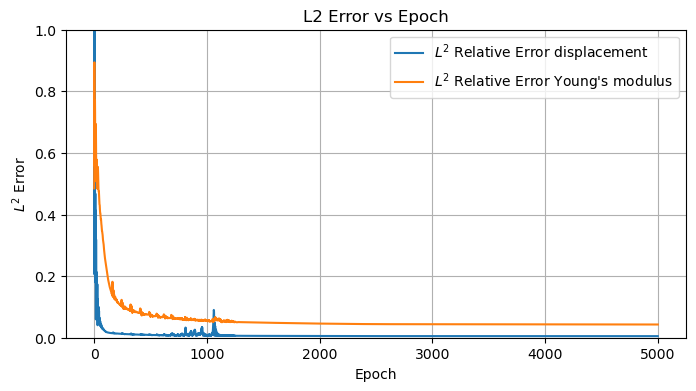

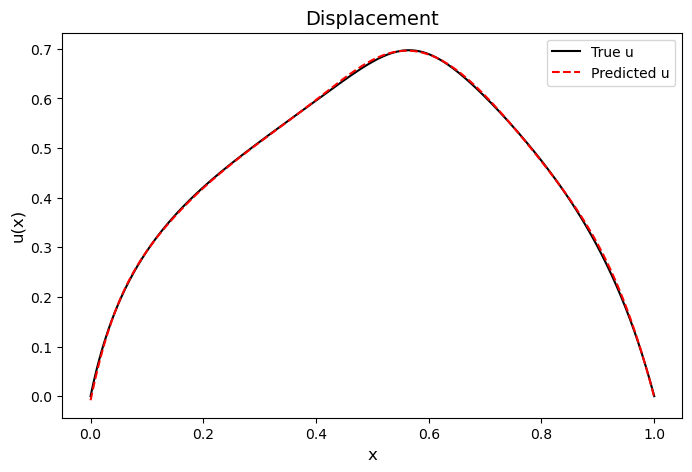

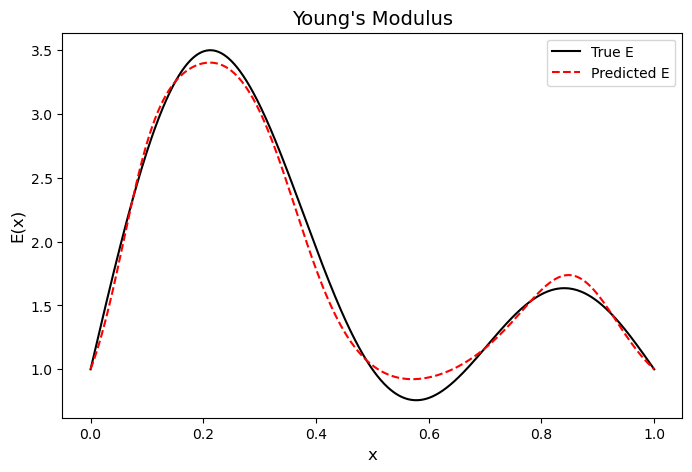

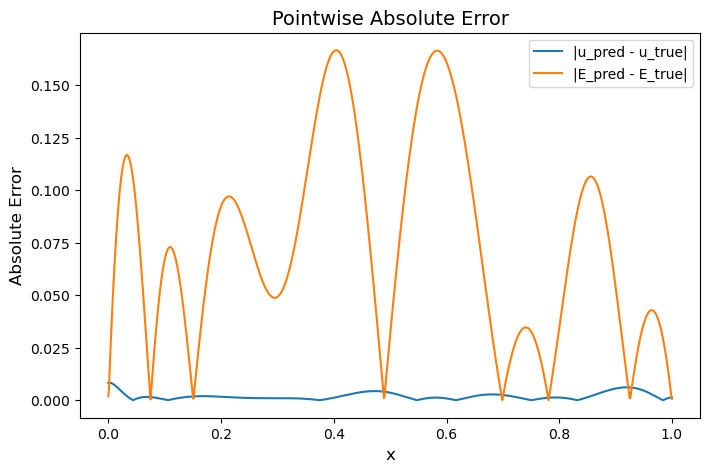

In [30]:
l2_err = L2_error(u_test.cpu(), u_pred.cpu())
print(f'L2 relative error: {l2_err.item():.4e}')

## Visualisation
## Plotting the L2 vs epoch error
plt.figure(figsize=(8, 4))
plt.plot(l2_error_list_u, label='$L^2$ Relative Error displacement')
plt.plot(l2_error_list_E, label='$L^2$ Relative Error Young\'s modulus')
plt.xlabel('Epoch')
plt.ylabel('$L^2$ Error')
plt.ylim(0, 1)
plt.title('L2 Error vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Results
plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), u_test.cpu().numpy(), 'k-', label='True u')
plt.plot(x_test.cpu().numpy(), u_pred.cpu().numpy(), 'r--', label='Predicted u')
plt.legend()
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.title('Displacement', fontsize=14)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), e_test.cpu().numpy(), 'k-', label='True E')
plt.plot(x_test.cpu().numpy(), E_pred.cpu().numpy(), 'r--', label='Predicted E')
plt.legend()
plt.xlabel('x', fontsize=12)
plt.ylabel('E(x)',fontsize=12)
plt.title('Young\'s Modulus', fontsize=14)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(x_test.cpu().numpy(), torch.abs(u_pred - u_test).cpu().numpy(), label='|u_pred - u_true|')
plt.plot(x_test.cpu().numpy(), torch.abs(E_pred - e_test).cpu().numpy(), label='|E_pred - E_true|')
plt.legend()
plt.xlabel('x', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.title('Pointwise Absolute Error', fontsize=14)
plt.show()
